In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import os
import importlib
import seaborn as sns

from collections import defaultdict
from scipy.stats.stats import pearsonr
from pandas.plotting import scatter_matrix
from scipy.stats import norm

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score


In [ ]:
df = pd.read_csv('C:/Users/ricky/Desktop/Scrivania/Data Mining/DM_2/dataframe_classification.csv',  header=0, parse_dates=True, squeeze=True)

In [ ]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1)#, join_axes=[dfX.index])
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [ ]:
class_name = 'Occupancy'
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

,Unnamed: 0,Temperature,Humidity,Light,CO2,HumidityRatio,Hours,Office_Hours,Working_day,Time_blocks_0,Time_blocks_1,Time_blocks_2,Time_blocks_3,Occupancy
0,0,23.7000,26.272,585.200000,749.200000,0.004764,14,1,1,0,0,1,0,1
1,1,23.7180,26.290,578.400000,760.400000,0.004773,14,1,1,0,0,1,0,1
2,2,23.7300,26.230,572.666667,769.666667,0.004765,14,1,1,0,0,1,0,1
3,3,23.7225,26.125,493.750000,774.750000,0.004744,14,1,1,0,0,1,0,1
4,4,23.7540,26.200,488.600000,779.000000,0.004767,14,1,1,0,0,1,0,1


In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc_X = MinMaxScaler()
columns = ['Temperature', 'Light', 'CO2', 'HumidityRatio']
sc_X.fit(np.array(df[columns]))
df[columns] = sc_X.transform(np.array(df[columns]))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
class_name = 'Occupancy'
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, stratify=y)

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
clf = MLPClassifier(random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

Accuracy 0.9141536964980544
F1-score [0.94119607 0.84106258]
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      3162
           1       0.73      0.98      0.84       950

    accuracy                           0.91      4112
   macro avg       0.86      0.94      0.89      4112
weighted avg       0.93      0.91      0.92      4112



In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(200,150,),solver='adam', max_iter = 160, shuffle = True, beta_1 = 0.9,activation='relu', early_stopping=False, momentum=0.9, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(200, 150), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=160,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

Accuracy 0.8207684824902723
F1-score [0.89493942 0.39040529]
              precision    recall  f1-score   support

           0       0.81      0.99      0.89      3162
           1       0.91      0.25      0.39       950

    accuracy                           0.82      4112
   macro avg       0.86      0.62      0.64      4112
weighted avg       0.84      0.82      0.78      4112



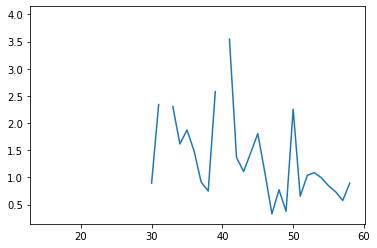

In [ ]:
plt.plot(clf.loss_curve_)
plt.show()

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(400,250,100,),solver='adam',batch_size=70, max_iter = 200, shuffle = True, beta_1 = 0.9,activation='identity', early_stopping=False, momentum=0.9, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

MLPClassifier(activation='identity', alpha=0.0001, batch_size=70, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(400, 250, 100), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

Accuracy 0.9520914396887159
F1-score [0.96907864 0.89368591]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3162
           1       0.92      0.87      0.89       950

    accuracy                           0.95      4112
   macro avg       0.94      0.92      0.93      4112
weighted avg       0.95      0.95      0.95      4112



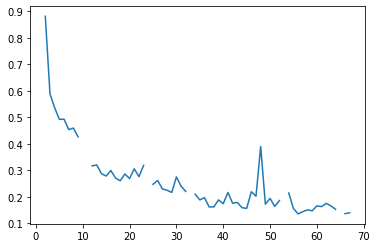

In [ ]:
plt.plot(clf.loss_curve_)
plt.show()

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(400,250,100,), solver='adam',batch_size=70, max_iter = 200, shuffle = False, beta_1 = 0.9, activation='identity', 
                    early_stopping=True, momentum=0.9, random_state=42)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

MLPClassifier(activation='identity', alpha=0.0001, batch_size=70, beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(400, 250, 100), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=False, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

Accuracy 0.9576848249027238
F1-score [0.97198068 0.91360477]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      3162
           1       0.86      0.97      0.91       950

    accuracy                           0.96      4112
   macro avg       0.93      0.96      0.94      4112
weighted avg       0.96      0.96      0.96      4112



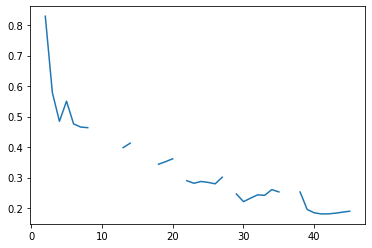

In [ ]:
plt.plot(clf.loss_curve_)
plt.show()

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(200,150,100,),solver='adam', max_iter = 200, shuffle = True, beta_1 = 0.9,activation='logistic', early_stopping=False, momentum=0.9, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(200, 150, 100), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

Accuracy 0.7789396887159533
F1-score [0.87422167 0.08826479]
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      3162
           1       0.94      0.05      0.09       950

    accuracy                           0.78      4112
   macro avg       0.86      0.52      0.48      4112
weighted avg       0.81      0.78      0.69      4112



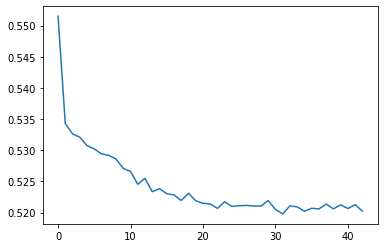

In [ ]:
plt.plot(clf.loss_curve_)
plt.show()

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(100,50,20), batch_size=10000,solver='adam', max_iter = 500, shuffle = True,
                    beta_1 = 0.9,activation='tanh', early_stopping=False, momentum=0.9, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print('Roc %s' % roc_auc_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

MLPClassifier(activation='tanh', alpha=0.0001, batch_size=10000, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 50, 20), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

Accuracy 0.7794260700389105
F1-score [0.87453313 0.08844221]
Roc 0.5229997669696062
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      3162
           1       0.98      0.05      0.09       950

    accuracy                           0.78      4112
   macro avg       0.88      0.52      0.48      4112
weighted avg       0.82      0.78      0.69      4112



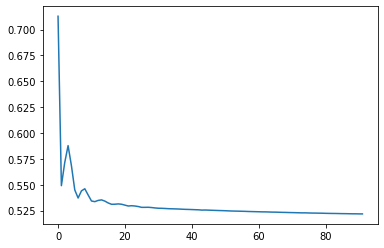

In [ ]:
plt.plot(clf.loss_curve_)
plt.show()

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(100,50,20), solver='adam',batch_size=10000, max_iter = 500, shuffle = True, 
                    beta_1 = 0.9, activation='tanh', early_stopping=True, momentum=0.9, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print('Roc %s' % roc_auc_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

MLPClassifier(activation='tanh', alpha=0.0001, batch_size=10000, beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(100, 50, 20), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

Accuracy 0.7796692607003891
F1-score [0.8746888  0.08853119]
Roc 0.5231578947368422
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      3162
           1       1.00      0.05      0.09       950

    accuracy                           0.78      4112
   macro avg       0.89      0.52      0.48      4112
weighted avg       0.83      0.78      0.69      4112



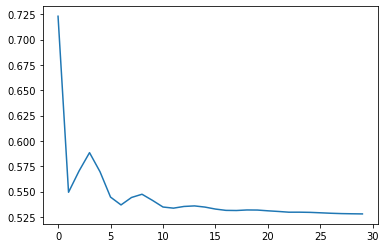

In [ ]:
plt.plot(clf.loss_curve_)#early stopping
plt.show()

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(200,150,100,), batch_size=150, solver='adam', max_iter = 200, shuffle = True, beta_1 = 0.9,
                    activation='relu', early_stopping=False, momentum=0.9, random_state=0)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print('F1-score %s' % roc_auc_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

MLPClassifier(activation='relu', alpha=0.0001, batch_size=150, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(200, 150, 100), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

Accuracy 0.8696498054474708
F1-score [0.91096346 0.75680581]
F1-score 0.8725337061819635
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      3162
           1       0.67      0.88      0.76       950

    accuracy                           0.87      4112
   macro avg       0.81      0.87      0.83      4112
weighted avg       0.89      0.87      0.88      4112



"Your loss is showing repetitive, step-like behavior.\nIt's probable that the input data seen by your model is itself exhibiting repetitive behavior. \nEnsure that shuffling is removing repetitive behavior from input data."

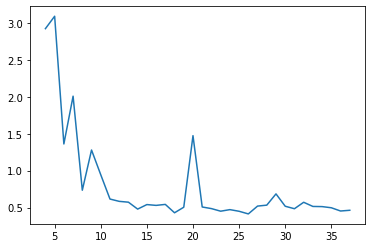

In [ ]:
'''Your loss is showing repetitive, step-like behavior.
It's probable that the input data seen by your model is itself exhibiting repetitive behavior. 
Ensure that shuffling is removing repetitive behavior from input data.'''

plt.plot(clf.loss_curve_)
plt.show()

In [ ]:
params = [{'solver': 'sgd', 'learning_rate': 'constant', 'momentum': 0.,'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': 0.9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'adaptive', 'momentum': 0.3,
           'learning_rate_init': 0.2},
          {'solver': 'adam', 'learning_rate': 'constant', 'learning_rate_init': 0.2},
          {'solver': 'adam', 'learning_rate': 'invscaling', 'learning_rate_init': 0.2},
          {'solver': 'adam', 'learning_rate': 'adaptive', 'learning_rate_init': 0.2}]

labels = ["constant learning-rate", "invscaling with momentum",
          "adaptive learning-rate", "adam constant", "adam invscaling", "adam adaptive"]

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning

constant learning-rate


MLPClassifier(activation='relu', alpha=0.0001, batch_size=3500, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(200, 150), learning_rate='constant',
              learning_rate_init=0.2, max_fun=15000, max_iter=200, momentum=0.0,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=0, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

training set score and loss: 0.769, 424713142656433070090480468450107807034720553601000938619539337653528731873943347254211544289991236518599615012309322572555919284346362639043245637632.000000


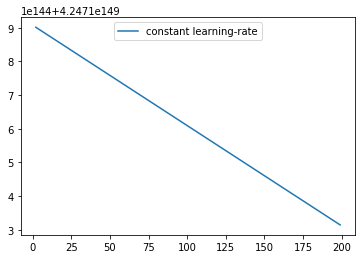

invscaling with momentum


MLPClassifier(activation='relu', alpha=0.0001, batch_size=3500, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(200, 150), learning_rate='invscaling',
              learning_rate_init=0.2, max_fun=15000, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=False, power_t=0.5,
              random_state=0, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

training set score and loss: 0.769, 17775764109503145152547106796398649098074224423586118527222901862216192365859762886894833721532707799307957339116958828812270829568.000000


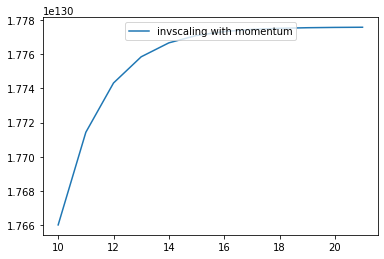

adaptive learning-rate


MLPClassifier(activation='relu', alpha=0.0001, batch_size=3500, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(200, 150), learning_rate='adaptive',
              learning_rate_init=0.2, max_fun=15000, max_iter=200, momentum=0.3,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=0, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

training set score and loss: 0.769, 206758940444247401510387035164328749584122635557295478373745414829543441314519403405734111231344640.000000


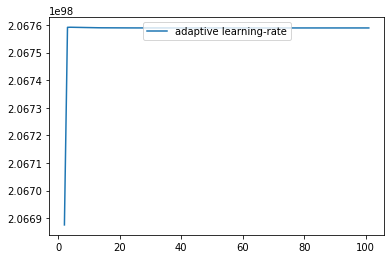

adam constant


MLPClassifier(activation='relu', alpha=0.0001, batch_size=3500, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(200, 150), learning_rate='constant',
              learning_rate_init=0.2, max_fun=15000, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=0, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

training set score and loss: 0.769, 0.541384


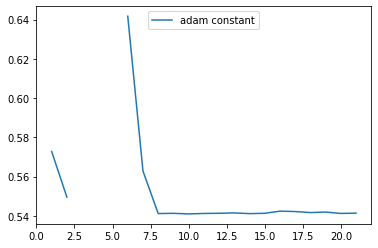

adam invscaling


MLPClassifier(activation='relu', alpha=0.0001, batch_size=3500, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(200, 150), learning_rate='invscaling',
              learning_rate_init=0.2, max_fun=15000, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=0, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

training set score and loss: 0.769, 0.541384


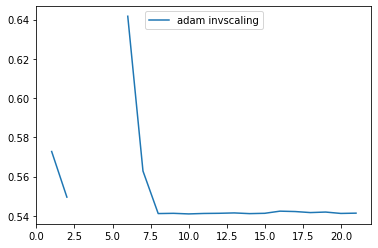

adam adaptive


MLPClassifier(activation='relu', alpha=0.0001, batch_size=3500, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(200, 150), learning_rate='adaptive',
              learning_rate_init=0.2, max_fun=15000, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=0, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

training set score and loss: 0.769, 0.541384


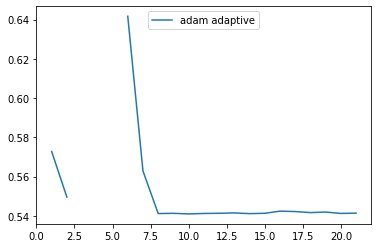

In [ ]:
for label, param in zip(labels, params):
    print(label)
    clf = MLPClassifier(hidden_layer_sizes=(200,150,), batch_size=3500, random_state=0, max_iter=200, **param)

    # some parameter combinations will not converge as can be seen on the
    # plots so they are ignored here
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        clf.fit(X, y)

    print("training set score and loss: %.3f, %f" % (clf.score(X, y), clf.loss_))
    plt.plot(clf.loss_curve_, label=label)
    plt.legend(loc="upper center")
    plt.show()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers

Using TensorFlow backend.
C:\Users\ricky\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ricky\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ricky\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ricky\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [ ]:
def build_model():
    
    n_feature = X_train.shape[1]
    model = Sequential()
    model.add(Dense(200, input_dim=n_feature, activation='relu'))
    model.add(Dense(150, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model




In [ ]:
model1 = build_model()

history1 = model1.fit(X_train, y_train, epochs=50, batch_size=10).history

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/50
16448/16448 [==============================] - 3s 168us/step - loss: 21.4778 - accuracy: 0.6677
Epoch 2/50
16448/16448 [==============================] - 2s 142us/step - loss: 5.7818 - accuracy: 0.7187
Epoch 3/50
16448/16448 [==============================] - 2s 144us/step - loss: 2.6413 - accuracy: 0.7603
Epoch 4/50
16448/16448 [==============================] - 2s 146us/step - loss: 1.3643 - accuracy: 0.7948
Epoch 5/50
16448/16448 [==============================] - 3s 154us/step - loss: 0.8310 - accuracy: 0.8193
Epoch 6/50
16448/16448 [==============================] - 3s 176us/step - loss: 0.6443 - accuracy: 0.8402
Epoch 7/50
16448/16448 [==============================] - 3s 166us/step - loss: 0.4850 - accuracy: 0.8543
Epoch 8/50
16448/16448 [==============================] - 2s 150us/step - loss: 0.4317 - accuracy: 0.8603
Epoch 9/50
16448/16448 [==============================] 

In [ ]:
model2 = build_model()

history2 = model2.fit(X_train, y_train, epochs=50, batch_size=50).history

Epoch 1/50
16448/16448 [==============================] - 1s 50us/step - loss: 55.2462 - accuracy: 0.6513
Epoch 2/50
16448/16448 [==============================] - 1s 34us/step - loss: 29.9681 - accuracy: 0.6658
Epoch 3/50
16448/16448 [==============================] - 1s 33us/step - loss: 15.2834 - accuracy: 0.6787
Epoch 4/50
16448/16448 [==============================] - 1s 33us/step - loss: 14.1276 - accuracy: 0.6856
Epoch 5/50
16448/16448 [==============================] - 1s 41us/step - loss: 11.3625 - accuracy: 0.7007
Epoch 6/50
16448/16448 [==============================] - 1s 40us/step - loss: 11.9644 - accuracy: 0.6925
Epoch 7/50
16448/16448 [==============================] - 1s 33us/step - loss: 5.7376 - accuracy: 0.7242
Epoch 8/50
16448/16448 [==============================] - 1s 33us/step - loss: 4.5271 - accuracy: 0.7473
Epoch 9/50
16448/16448 [==============================] - 1s 32us/step - loss: 4.0237 - accuracy: 0.7549
Epoch 10/50
16448/16448 [========================

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Cross-Entropy')

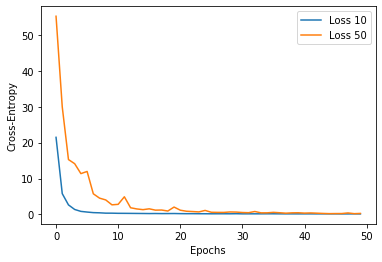

In [ ]:
plt.plot(history1['loss'], label='Loss 10')
plt.plot(history2['loss'], label='Loss 50')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

In [ ]:
test_loss_1, test_acc_1 = model1.evaluate(X_test, y_test)
test_loss_2, test_acc_2 = model2.evaluate(X_test, y_test)

print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))

4112/4112 [==============================] - 0s 24us/step
Loss 0.158025, Accuracy 0.939202
Loss 1.374072, Accuracy 0.816877


In [ ]:
y_pred = model1.predict(X_test).astype(int)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7767509727626459
F1-score [0.87323944 0.06517312]
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      3162
           1       1.00      0.03      0.07       950

    accuracy                           0.78      4112
   macro avg       0.89      0.52      0.47      4112
weighted avg       0.83      0.78      0.69      4112



In [ ]:
model3 = build_model()

history3 = model3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=10).history

Train on 16448 samples, validate on 4112 samples
Epoch 1/100
16448/16448 [==============================] - 3s 175us/step - loss: 28.4045 - accuracy: 0.6697 - val_loss: 0.6619 - val_accuracy: 0.7590
Epoch 2/100
16448/16448 [==============================] - 3s 162us/step - loss: 10.6913 - accuracy: 0.6998 - val_loss: 5.8978 - val_accuracy: 0.8047
Epoch 3/100
16448/16448 [==============================] - 3s 158us/step - loss: 4.3236 - accuracy: 0.7428 - val_loss: 2.4082 - val_accuracy: 0.4183
Epoch 4/100
16448/16448 [==============================] - 3s 163us/step - loss: 1.8163 - accuracy: 0.7778 - val_loss: 0.2354 - val_accuracy: 0.8850
Epoch 5/100
16448/16448 [==============================] - 3s 178us/step - loss: 1.0485 - accuracy: 0.8078 - val_loss: 0.4902 - val_accuracy: 0.8589
Epoch 6/100
16448/16448 [==============================] - 3s 168us/step - loss: 0.6737 - accuracy: 0.8326 - val_loss: 0.4421 - val_accuracy: 0.8621
Epoch 7/100
16448/16448 [==============================

In [ ]:
test_loss_3, test_acc_3 = model3.evaluate(X_test, y_test)

print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))
print('Loss %f, Accuracy %f' % (test_loss_3, test_acc_3))

4112/4112 [==============================] - 0s 22us/step
Loss 0.158025, Accuracy 0.939202
Loss 1.374072, Accuracy 0.816877
Loss 0.070807, Accuracy 0.973006


Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Cross-Entropy')

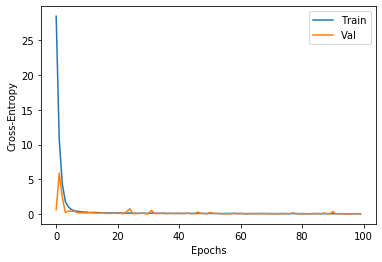

In [ ]:
plt.plot(history3['loss'], label='Train')
plt.plot(history3['val_loss'], label='Val')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend()
plt.show()

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=50)
mc = ModelCheckpoint('best_model_NOREG.h5', monitor='val_loss', save_best_only=True)

model4 = build_model()
history4 = model4.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150, 
                      batch_size=10, callbacks=[es,mc]).history

Train on 13158 samples, validate on 3290 samples
Epoch 1/150
13158/13158 [==============================] - 2s 158us/step - loss: 29.4295 - accuracy: 0.6582 - val_loss: 7.3482 - val_accuracy: 0.7985
Epoch 2/150
13158/13158 [==============================] - 2s 140us/step - loss: 10.5944 - accuracy: 0.7024 - val_loss: 5.4129 - val_accuracy: 0.7985
Epoch 3/150
13158/13158 [==============================] - 2s 138us/step - loss: 5.1903 - accuracy: 0.7358 - val_loss: 2.8036 - val_accuracy: 0.4401
Epoch 4/150
13158/13158 [==============================] - 2s 139us/step - loss: 3.4870 - accuracy: 0.7637 - val_loss: 3.0614 - val_accuracy: 0.8040
Epoch 5/150
13158/13158 [==============================] - 2s 143us/step - loss: 1.5954 - accuracy: 0.7958 - val_loss: 1.2824 - val_accuracy: 0.6520
Epoch 6/150
13158/13158 [==============================] - 2s 140us/step - loss: 1.2232 - accuracy: 0.8077 - val_loss: 0.6454 - val_accuracy: 0.8593
Epoch 7/150
13158/13158 [==============================

In [ ]:
test_loss_4, test_acc_4 = model4.evaluate(X_test, y_test)

print('Loss %f, Accuracy %f' % (test_loss_1, test_acc_1))
print('Loss %f, Accuracy %f' % (test_loss_2, test_acc_2))
print('Loss %f, Accuracy %f' % (test_loss_3, test_acc_3))
print('Loss %f, Accuracy %f' % (test_loss_4, test_acc_4))

4112/4112 [==============================] - 0s 23us/step
Loss 0.158025, Accuracy 0.939202
Loss 1.374072, Accuracy 0.816877
Loss 0.070807, Accuracy 0.973006
Loss 0.085440, Accuracy 0.965953


In [ ]:
from keras.regularizers import l2

def build_L2_model():
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    h_dim=100
    model.add(Dense(h_dim, activation='relu', input_shape=(n_feature,), kernel_regularizer=l2(0.01)))
    model.add(Dense(h_dim, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(h_dim, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(h_dim, activation='relu', kernel_regularizer=l2(0.01)))
    #linear activation
    model.add(Dense(1))

    #compile the model
    adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    return model

In [ ]:
mc = ModelCheckpoint('best_model_L2.h5', monitor='val_loss', save_best_only=True)

L2_model = build_L2_model()
h_L2 = L2_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150, 
                    batch_size=10, callbacks=[es,mc]).history

Train on 13158 samples, validate on 3290 samples
Epoch 1/150
13158/13158 [==============================] - 2s 190us/step - loss: 11.7163 - accuracy: 0.0592 - val_loss: 11.7680 - val_accuracy: 0.2325
Epoch 2/150
13158/13158 [==============================] - 2s 159us/step - loss: 11.7965 - accuracy: 0.2307 - val_loss: 11.7679 - val_accuracy: 0.2325
Epoch 3/150
13158/13158 [==============================] - 2s 159us/step - loss: 11.7965 - accuracy: 0.2307 - val_loss: 11.7679 - val_accuracy: 0.2325
Epoch 4/150
13158/13158 [==============================] - 2s 162us/step - loss: 11.7965 - accuracy: 0.2307 - val_loss: 11.7679 - val_accuracy: 0.2325
Epoch 5/150
13158/13158 [==============================] - 2s 161us/step - loss: 11.7965 - accuracy: 0.2307 - val_loss: 11.7679 - val_accuracy: 0.2325
Epoch 6/150
13158/13158 [==============================] - 2s 161us/step - loss: 11.7965 - accuracy: 0.2307 - val_loss: 11.7679 - val_accuracy: 0.2325
Epoch 7/150
13158/13158 [====================

In [ ]:
from keras.layers import Dropout

def build_DROPOUT_model():
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    h_dim=100
    model.add(Dense(h_dim, activation='relu', input_shape=(n_feature,)))
    model.add(Dropout(0.2))
    model.add(Dense(h_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(h_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(h_dim, activation='relu'))
    #linear activation
    model.add(Dense(1))

    #compile the model
    adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    return model

In [ ]:
mc = ModelCheckpoint('best_model_DROPOUT.h5', monitor='val_loss', save_best_only=True)

DROPOUT_model = build_DROPOUT_model()
h_DROPOUT = DROPOUT_model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                              epochs=150, batch_size=10, callbacks=[es,mc]).history

Train on 13158 samples, validate on 3290 samples
Epoch 1/150
13158/13158 [==============================] - 3s 210us/step - loss: 11.5746 - accuracy: 1.5200e-04 - val_loss: 11.7679 - val_accuracy: 0.0000e+00
Epoch 2/150
13158/13158 [==============================] - 2s 186us/step - loss: 11.7966 - accuracy: 7.5999e-05 - val_loss: 11.7679 - val_accuracy: 0.0000e+00
Epoch 3/150
13158/13158 [==============================] - 3s 220us/step - loss: 11.7965 - accuracy: 0.0000e+00 - val_loss: 11.7679 - val_accuracy: 0.0000e+00
Epoch 4/150
13158/13158 [==============================] - 2s 187us/step - loss: 11.7965 - accuracy: 0.0000e+00 - val_loss: 11.7679 - val_accuracy: 0.0000e+00
Epoch 5/150
13158/13158 [==============================] - 2s 187us/step - loss: 11.7965 - accuracy: 0.0000e+00 - val_loss: 11.7679 - val_accuracy: 0.0000e+00
Epoch 6/150
13158/13158 [==============================] - 2s 187us/step - loss: 11.7965 - accuracy: 0.0000e+00 - val_loss: 11.7679 - val_accuracy: 0.0000e+

In [ ]:
# laod best models and test them
from keras.models import load_model

best_NOREG_model = load_model('best_model_NOREG.h5')
best_L2_model = load_model('best_model_L2.h5')
best_DROPOUT_model = load_model('best_model_DROPOUT.h5')

loss_NOREG, acc_NOREG = best_NOREG_model.evaluate(X_test, y_test)
loss_L2, acc_L2 = best_L2_model.evaluate(X_test, y_test)
loss_DROPOUT, acc_DROPOUT = best_DROPOUT_model.evaluate(X_test, y_test)

4112/4112 [==============================] - 0s 48us/step


In [ ]:
print('Loss %f, Accuracy %f' % (loss_NOREG, acc_NOREG))
print('Loss %f, Accuracy %f' % (loss_L2, acc_L2))
print('Loss %f, Accuracy %f' % (loss_DROPOUT, acc_DROPOUT))

Loss 0.052965, Accuracy 0.983706
Loss 11.790784, Accuracy 0.231031
Loss 11.790784, Accuracy 0.000000


In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
def build_model(n_layers=2, h_dim=64, activation='relu', optimizer='adam'):
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    
    model.add(Dense(h_dim, activation=activation, input_shape=(n_feature,)))
    for i in range(n_layers-1):
        model.add(Dense(h_dim, activation=activation))
    #linear activation
    model.add(Dense(1))

    #compile the model
    adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    
    return model

In [ ]:
n_layers = [1, 2, 3]
h_dim = [100, 150, 200]
activation = ['relu', 'sigmoid']
optimizer = ['adagrad', 'adam']
params = dict(optimizer=optimizer, n_layers=n_layers, h_dim=h_dim, activation=activation)

In [ ]:
model = KerasRegressor(build_fn=build_model)

rnd = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=5, cv=3)
rnd_result = rnd.fit(X_train, y_train, epochs=100, batch_size=100, verbose=0)

4386/4386 [==============================] - 0s 65us/step


In [ ]:
print("Best: %f using %s" % (-rnd_result.best_score_, rnd_result.best_params_))
means = rnd_result.cv_results_['mean_test_score']
stds = rnd_result.cv_results_['std_test_score']
params = rnd_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (-mean, stdev, param))

Best: 3.557890 using {'optimizer': 'adam', 'n_layers': 1, 'h_dim': 150, 'activation': 'relu'}
3.557890 (0.109130) with: {'optimizer': 'adam', 'n_layers': 1, 'h_dim': 150, 'activation': 'relu'}
8.985625 (3.907697) with: {'optimizer': 'adam', 'n_layers': 2, 'h_dim': 200, 'activation': 'relu'}
9.013676 (3.898100) with: {'optimizer': 'adam', 'n_layers': 2, 'h_dim': 100, 'activation': 'relu'}
11.796502 (0.108481) with: {'optimizer': 'adagrad', 'n_layers': 1, 'h_dim': 100, 'activation': 'relu'}
5.219789 (4.704570) with: {'optimizer': 'adagrad', 'n_layers': 1, 'h_dim': 200, 'activation': 'sigmoid'}


In [ ]:
print("Best: %f using %s" % (-rnd_result.best_score_, rnd_result.best_params_))
means = rnd_result.cv_results_['mean_test_score']
stds = rnd_result.cv_results_['std_test_score']
params = rnd_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (-mean, stdev, param))

Best: 3.557890 using {'optimizer': 'adam', 'n_layers': 1, 'h_dim': 150, 'activation': 'relu'}
3.557890 (0.109130) with: {'optimizer': 'adam', 'n_layers': 1, 'h_dim': 150, 'activation': 'relu'}
8.985625 (3.907697) with: {'optimizer': 'adam', 'n_layers': 2, 'h_dim': 200, 'activation': 'relu'}
9.013676 (3.898100) with: {'optimizer': 'adam', 'n_layers': 2, 'h_dim': 100, 'activation': 'relu'}
11.796502 (0.108481) with: {'optimizer': 'adagrad', 'n_layers': 1, 'h_dim': 100, 'activation': 'relu'}
5.219789 (4.704570) with: {'optimizer': 'adagrad', 'n_layers': 1, 'h_dim': 200, 'activation': 'sigmoid'}


In [ ]:
clf = rnd_result.best_estimator_.model

loss, acc = clf.evaluate(X_test, y_test)
print('Loss %f, Accuracy %f' % (loss, acc))

4112/4112 [==============================] - 0s 76us/step
Loss 11.790784, Accuracy 0.000000



# STOP  ⚠️🛑 ✋ 


In [ ]:
import sys
!{sys.executable} -m pip install tensorflow==1.14.0

  Using cached tensorflow-1.14.0-cp37-cp37m-win_amd64.whl (68.3 MB)


In [ ]:
import tensorflow as tf
print(tf.__version__)

C:\Users\ricky\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ricky\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ricky\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ricky\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

1.14.0


C:\Users\ricky\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ricky\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ricky\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ricky\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.